In [33]:
import json
from pathlib import Path

import astropy.uncertainty as unc
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LMLSQFitter
from astropy.time import Time
import astropy.uncertainty as unc

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask

finfo = np.finfo(float)

In [34]:
disk_profile = Disk(
        name="halpha_disk",
        center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
        inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3, loc=1e3, scale=1e2),
        delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4, loc=5e3, scale=5e2),
        inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 8, scale=np.pi / 4),
        sigma=Parameter(name="sigma", distribution="log_uniform", low=2e2, high=1e4, loc=1e3, scale=1e2),
        q=Parameter(name="q", distribution="normal", low=0.5, high=4, loc=2, scale=1),
        eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1, loc=0.5, scale=0.25),
        apocenter=Parameter(name="apocenter", distribution="uniform", circular=True, low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
        scale=Parameter(name="scale", distribution="uniform", low=0, high=1, loc=0.5, scale=0.1),
        offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=True, value=0)
    )

halpha_narrow_line = Line(
    name="halpha_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1),
)

halpha_broad_line = Line(
    name="halpha_broad",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e3, high=5e4, loc=1e2, scale=1e1),
)

niir_narrow_line = Line(
    name="niir_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6583.46 - 5, high=6583.46 + 5, loc=6583.46, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

niil_narrow_line = Line(
    name="niil_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548.05 - 5, high=6548.05 + 5, loc=6548.05, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

siir_narrow_line = Line(
    name="siir_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6730.81 - 5, high=6730.81 + 5, loc=6730.81, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

siil_narrow_line = Line(
    name="siil_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6716.44 - 5, high=6716.44 + 5, loc=6716.44, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1)

In [35]:
ingest_dir = Path("/Users/nmearl/Downloads/ZTF-DPEs-main/SDSSspectroscopy")

# obj_tab = Table.read("/Users/nmearl/Downloads/ZTF-DPEs-main/object_info.cds", format='ascii.cds')
# obj_tab['name'] = [x.strip() for x in obj_tab['ZTF']]
rs_tab = Table.read("/Users/nmearl/research/tde_agn_comparison/templates/redshifts.csv", format='ascii.ecsv')

output_dir = Path("/Users/nmearl/research/tde_agn_comparison")

for file_path in ingest_dir.glob("*.txt"):
    label = file_path.stem.split('_')[0]

    if label not in rs_tab['name']:
        continue

    tab = Table.read(file_path, format='ascii.basic', names=['wave', 'flux', 'flux_err'])
    redshift = rs_tab[rs_tab['name'] == label]['redshift'].value.data[0]

    if not redshift:
        print(f"{label} has missing redshift")
        continue

    # ==============
    # Parse and transform data
    # ==============
    rest_wave = tab['wave'] / (1 + redshift)

    if label != "ZTF18aaymybb":
        flux = tab['flux'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA
    else:
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA

    # wave = wave[ha_mask]
    # flux = flux[ha_mask]
    # flux_err = flux_err[ha_mask]

    # uflux = unc.normal(flux, std=flux_err, n_samples=10000).to(u.mJy, u.spectral_density(wave))
    # flux, flux_err = uflux.pdf_median(), uflux.pdf_std()
    # snr = flux / flux_err

    flux = flux.to(u.mJy, u.spectral_density(wave))
    flux_err = flux_err.to(u.mJy, u.spectral_density(wave))
    snr_mask = (flux_err.value > 0) & (flux_err.value < 1) & ~np.isnan(flux.value) & ~np.isnan(flux_err.value)

    # flux_err[snr < 3] = np.abs(flux[snr < 3]) * 0.1
    wave = wave[snr_mask]
    flux = flux[snr_mask]
    flux_err = flux_err[snr_mask]

    if len(flux) == 0:
        print(f"{label} has no data")
        continue

    Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(output_dir / "data" / f"{label}.csv", format='ascii.csv', overwrite=True)

    # ==============
    # Update template
    # ==============
    template = Template(
        name=label,
        redshift=redshift,
        data_path=str(output_dir / "data" / f"{label}.csv"),
        # data_path=f"/datasets/transient-data/{label}.csv",
        # data_path=f"/home/kasm-user/research/data/{label}.csv",
        disk_profiles=[
            disk_profile,
        ],
        line_profiles=[
            halpha_narrow_line,
            halpha_broad_line,
            niir_narrow_line,
            niil_narrow_line,
            siir_narrow_line,
            siil_narrow_line,
        ],
        white_noise=white_noise,
        mask=[Mask(lower_limit=6400, upper_limit=6800)]
    )

    template.name = label
    template.redshift = redshift

    for prof in template.disk_profiles:
        prof.scale.high = flux.max().value * 1.1

        for param in prof._independent():
            if "log" in param.distribution:
                param.scale = 10 ** ((np.log10(param.high) 
                                    - np.log10(param.low)) / 2)
            else:
                param.scale = ((param.high - param.low) / 2)

    for prof in template.line_profiles:
        prof.amplitude.high = flux.max().value * 1.1

        for param in prof._independent():
            if "log" in param.distribution:
                param.scale = 10 ** ((np.log10(param.high) 
                                    - np.log10(param.low)) / 2)
            else:
                param.scale = ((param.high - param.low) / 2)

    with open(output_dir / "templates" / f"{label}.json", "w") as f:
        json.dump(template.model_dump(), f, indent=4)

False


<ErrorbarContainer object of 3 artists>

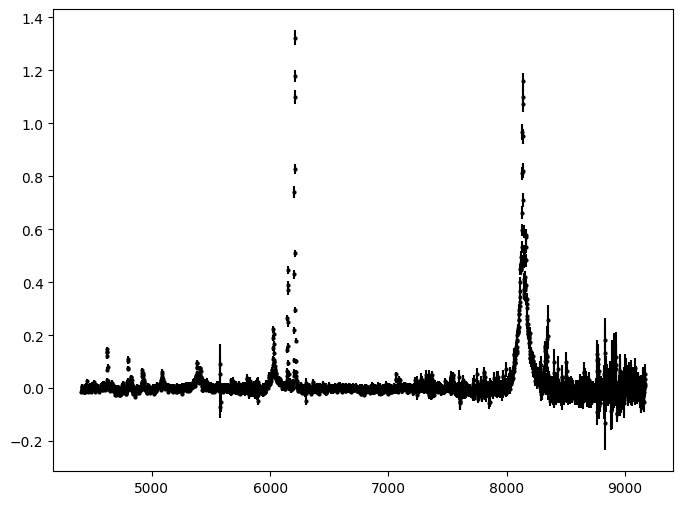

In [36]:
lvn_tab = Table.read("/Users/nmearl/research/tde_agn_comparison/data/ZTF19aalckts.csv")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

lvn_tab['wave'] = lvn_tab['wave'] #/ (1 + 0.017246318469858826)
mask = (lvn_tab['wave'] > 6350) & (lvn_tab['wave'] < 6800)
# lvn_tab = lvn_tab[mask]

print(np.any(np.isinf(1 / lvn_tab['flux_err'])))

ax.errorbar(lvn_tab['wave'], lvn_tab['flux'], yerr=lvn_tab['flux_err'], fmt='o', color='black', markersize=2, label="ZTF18aabylvn")

In [37]:
# temp_path = output_dir / "templates"

# for file_path in temp_path.glob("*.json"):
#     with open(file_path, "r") as f:
#         template = Template(**json.load(f))

#     for prof in template.disk_profiles:
#         prof.apocenter.distribution = "circular"

#     with open(file_path, "w") as f:
#         json.dump(template.model_dump(), f, indent=4)

In [38]:
np.rad2deg(np.arctan2(
            np.mean(np.sin(2 * np.pi / 16)),
            np.mean(np.cos(2 * np.pi / 16)),
        ) % (2 * np.pi))



np.float64(22.500000000000004)

In [39]:
a = 2 * np.pi / 8
b = 2 * np.pi / 8 * 7

print(np.rad2deg(a), np.rad2deg(b))
np.rad2deg(np.median([a, b])), np.rad2deg(np.arctan2(np.mean(np.sin([a, b])), np.mean(np.cos([a, b]))) % (2 * np.pi))

45.0 315.0


(np.float64(180.0), np.float64(360.0))

In [40]:
a = np.random.uniform(-np.pi, np.pi, 1)
b = a % (2 * np.pi)
a, a + np.pi, a % (2 * np.pi), (b + np.pi) % (2 * np.pi) - np.pi

(array([-1.3474455]),
 array([1.79414715]),
 array([4.9357398]),
 array([-1.3474455]))

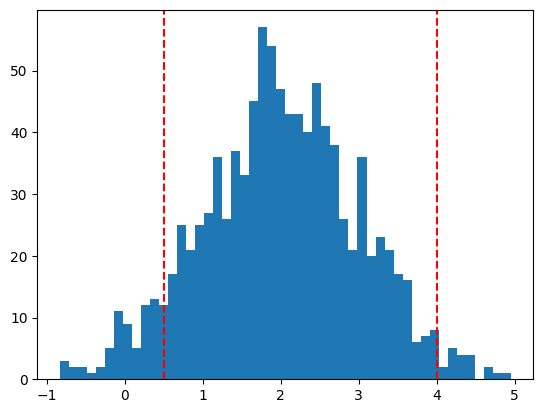

In [ ]:
a = np.random.normal(0, 0.01, 1000)
b = np.random.normal(0, 0.01, 1000)

a = 0
b = -0.1

fig, ax = plt.subplots()

# inc = np.random.normal(np.pi / 8, np.pi / 4, 1000)
inc = np.random.normal(2, 1, 1000)

# ax.hist(np.rad2deg(inc), bins=50)
# ax.axvline(0, color='red', linestyle='--')
# ax.axvline(90, color='red', linestyle='--')
ax.hist(inc, bins=50)
ax.axvline(0.5, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')

In [42]:
np.rad2deg(np.pi / 8)

np.float64(22.5)